<h1> mGluR3 | Cpd1</h1>

<h3>IPython accepts some shell commands like ls or pwd.
First check whether you are in the correct directory</h3>

In [1]:
pwd

u'/home/seeliged/projects/mGluR3/design/MD/cpds_01/analysis'

<h3>The next lines import some modules we need for the analysis</h3>

In [49]:
import pyemma
%pylab inline
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
from glob import glob
from rdkit import Chem
from rdkit.Chem import AllChem
from pmx import *
from pmx.parser import *
from IPython.display import SVG
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolDrawing, DrawingOptions


Populating the interactive namespace from numpy and matplotlib


<h4> Define a function to make running averages</h4>

In [50]:
def smooth(x, window_len=11, window='hanning'):
    
    s = r_[2*x[0]-x[window_len:1:-1],x,2*x[-1]-x[-1:-window_len:-1]]
    w = eval( window+'(window_len)')
    y = convolve(w/w.sum(),s,mode='same')
    return y[window_len-1:-window_len+1]

In [51]:
def rmsd(m1, m2):
    rd = 0
    tm = float( len( m1.atoms ) )
    for a1, a2 in zip(m1.atoms,m2.atoms):
        for i in range(3):
            xd = a1.x[i] - a2.x[i]
            rd+= xd*xd
    return np.sqrt(rd/tm)

In [52]:
def plot_free_energy(xall, yall, weights=None, ax=None, nbins=100, offset=0.1, range=((-180,180),(-180,180)),
                     cmap='spectral', cbar=True, cbar_label='Free energy (kT)'):

    z, x, y = np.histogram2d(xall, yall, bins=nbins, weights=weights, range = range)
    z += offset
    # compute free energies
    F = -np.log(z)
    # do a contour plot
    extent = [x[0], x[-1], y[0], y[-1]]
    if ax is None:
        ax = gca()
    CS = ax.contourf(F.T, 100, extent=extent, cmap=cmap)
    if cbar:
        cbar = colorbar(CS)
        if cbar_label is not None:
            cbar.ax.set_ylabel(cbar_label)

    return ax, gcf()


In [53]:
#sd = Chem.SDMolSupplier('BI01591452.sdf')
mol = Chem.MolFromMol2File('MOL.mol2')

AllChem.Compute2DCoords(mol)

0

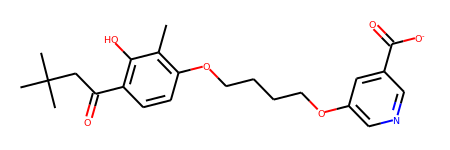

In [54]:
#from rdkit.Chem import Draw
#f = Draw.MolToMPL(mol, size=(150,150))
#axis('off');
#for i in range(m.GetNumAtoms()):
#    opts
mol

<h3> The first analysis we do is to compute dihedrals angles from the simulation data. Therefore we need to define the dihedral angles using the atom indices. First, read the pdb file:</h3>

In [55]:
from pmx import *

In [56]:
m = Model('unique.pdb')

<h3> Now we get the paths of the trajectories into a list. We also need a reference pdb file</h3>

In [57]:
from glob import glob
traj_list = glob('*.xtc')
topfile = 'unique.pdb'
print traj_list

['run1.xtc', 'run2.xtc', 'run3.xtc', 'run4.xtc', 'run5.xtc']


<h3> The atom names which define a dihdral we get from a visualizer (pymol, moe). Then we can use the fetchm method to extract these atoms. Note that indices of python lists start at 0 whereas a pdb file starts with 1. We therefore have to decrement the atom id by 1.</h3>

In [58]:
atom_names1 = ['C5','O2','C4','C3']
atom_names2 = ['O2','C4','C3','C2']
atom_names3 = ['C4','C3','C2','C1']
atom_names4 = ['C3','C2','C1','O1']
atom_names5 = ['C2','C1','O1','C22']
#atom_names3 = ['N2','C11','N6','C19']
atoms1 = m.residues[0].fetchm( atom_names1 )
atoms2 = m.residues[0].fetchm( atom_names2 )
atoms3 = m.residues[0].fetchm( atom_names3 )
atoms4 = m.residues[0].fetchm( atom_names4 )
atoms5 = m.residues[0].fetchm( atom_names5 )
#atoms3 = m.residues[0].fetchm( atom_names3 )
lst = []
lst.append( [] )
lst.append( [] )
lst.append( [] )
lst.append( [] )
lst.append( [] )
for atom in atoms1:
    print atom.name, atom.id-1
    lst[0].append( atom.id - 1 )
for atom in atoms2:
    print atom.name, atom.id -1
    lst[1].append( atom.id - 1 )
for atom in atoms3:
    print atom.name, atom.id -1
    lst[2].append( atom.id - 1 )
for atom in atoms4:
    print atom.name, atom.id -1
    lst[3].append( atom.id - 1 )
for atom in atoms5:
    print atom.name, atom.id -1
    lst[4].append( atom.id - 1 )


C5 6
O2 5
C4 4
C3 3
O2 5
C4 4
C3 3
C2 2
C4 4
C3 3
C2 2
C1 1
C3 3
C2 2
C1 1
O1 0
C2 2
C1 1
O1 0
C22 26


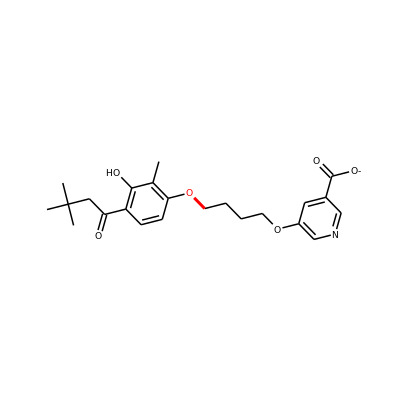

In [61]:
DrawingOptions.includeAtomNumbers = False
DrawingOptions.elemDict = {0:[0.5,0.5,0.5]}
DrawingOptions.bondLineWidth = 1.5
DrawingOptions.atomLabelFontSize = 16
Draw.MolToImage(mol, size=(400,400), highlightAtoms = lst[0][1:-1])

In [62]:
Draw.MolToImageFile(mol,'dih1.png',size=(400,400), highlightAtoms = lst[0][1:-1])

In [25]:
b = mol.GetBondBetweenAtoms(1,7)

[4, 3]


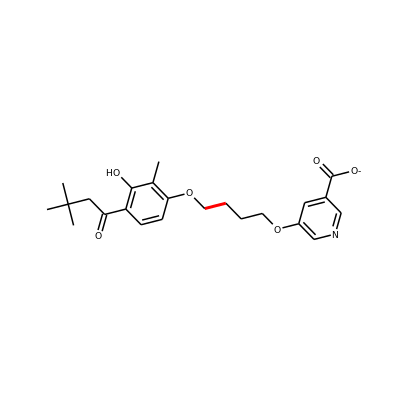

In [63]:
print lst[1][1:-1]
Draw.MolToImage(mol, size=(400,400), highlightAtoms = lst[1][1:-1])

In [65]:
Draw.MolToImageFile(mol,'dih2.png',size=(400,400), highlightAtoms = lst[1][1:-1])

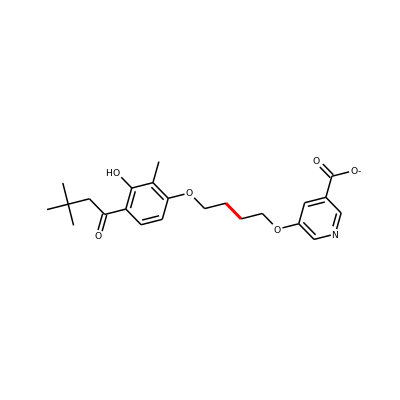

In [66]:
Draw.MolToImage(mol, size=(400,400), highlightAtoms = lst[2][1:-1])

In [80]:
Draw.MolToImageFile(mol,'dih3.png',size=(400,400), highlightAtoms = lst[2][1:-1])
Draw.MolToImageFile(mol,'dih4.png',size=(400,400), highlightAtoms = lst[3][1:-1])
Draw.MolToImageFile(mol,'dih5.png',size=(400,400), highlightAtoms = lst[4][1:-1])

<h3> Now we have a list which defines two dihedral angles.  In the next step we initialize a featurizer with our pdb file.</h3>

In [69]:
# pdb file
feat = coor.featurizer(topfile)

<h3> ..and add the list of dihedrals to the featurizer...</h3>

In [70]:
feat.add_dihedrals(lst)

<h3> In the next step we extract the features (the two dihedrals) from the trajectories<h3>

In [71]:
inp = coor.load(traj_list, feat)

Box(children=(Text(value=u''), IntProgress(value=0)))

<h3> inp is a list of arrays containing the extracted features. inp[0] contains the data from the first trajectory, inp[-1] the data from the last.</h3> 

In [72]:
#print inp[1][:,0]
ref_1 = 49.2
ref_2 = 58.2

<h3> Now we plot a 2d histogram of the two dihedral angles.</h3>

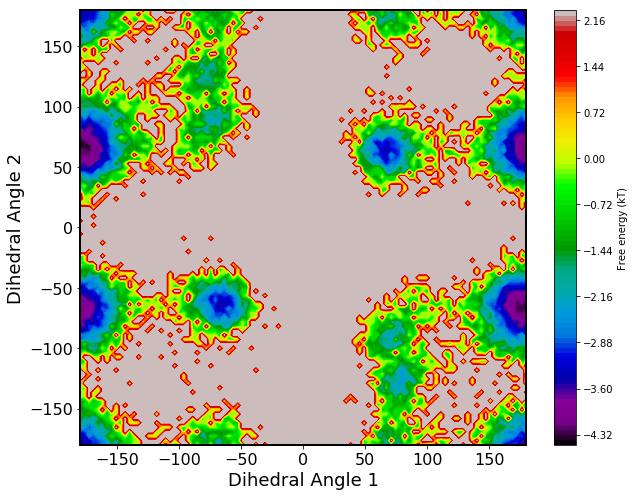

In [74]:
figure(figsize=(10,8))
#mplt.plot_free_energy(np.vstack(inp)[:,0]*180./pi,np.vstack(inp)[:,1]*180./pi, offset = 0.1)
plot_free_energy(np.vstack(inp)[:,0]*180./pi,np.vstack(inp)[:,1]*180./pi, offset = 0.1)
for p in gca().spines.values(): p.set_lw(2)
#plot(ref_1, ref_2,'ko', markersize=10)
#text(ref_1, ref_2+20,"Xray Dihedrals", fontsize=20)
xticks(fontsize=16)
yticks(fontsize=16)
xlabel('Dihedral Angle 1', fontsize=18)
ylabel('Dihedral Angle 2', fontsize=18)
xlim(-180,180)
ylim(-180,180)
savefig('dih1_vs_dih2.png', bbox_inches = 'tight')

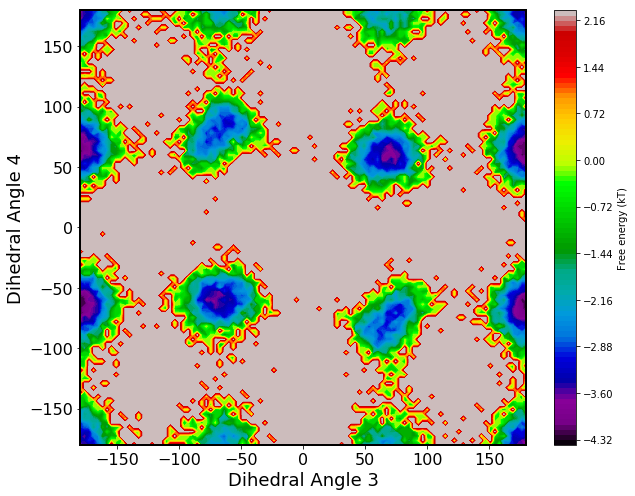

In [76]:
figure(figsize=(10,8))
#mplt.plot_free_energy(np.vstack(inp)[:,0]*180./pi,np.vstack(inp)[:,1]*180./pi, offset = 0.1)
plot_free_energy(np.vstack(inp)[:,2]*180./pi,np.vstack(inp)[:,3]*180./pi, offset = 0.1)
for p in gca().spines.values(): p.set_lw(2)
#plot(ref_1, ref_2,'ko', markersize=10)
#text(ref_1, ref_2+20,"Xray Dihedrals", fontsize=20)
xticks(fontsize=16)
yticks(fontsize=16)
xlabel('Dihedral Angle 3', fontsize=18)
ylabel('Dihedral Angle 4', fontsize=18)
xlim(-180,180)
ylim(-180,180)
savefig('dih3_vs_dih4.png', bbox_inches = 'tight')

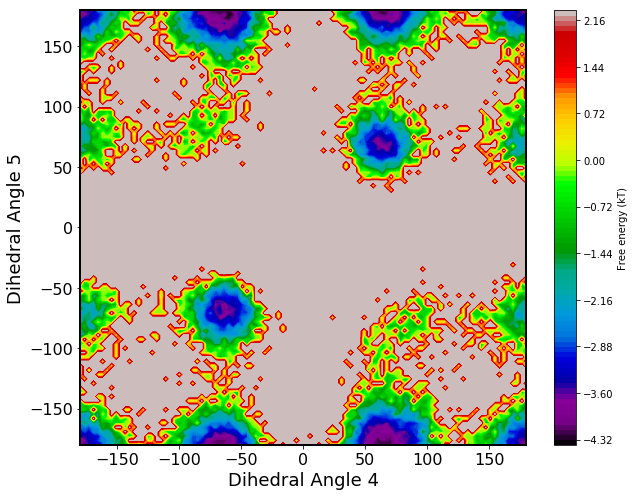

In [81]:
figure(figsize=(10,8))
#mplt.plot_free_energy(np.vstack(inp)[:,0]*180./pi,np.vstack(inp)[:,1]*180./pi, offset = 0.1)
plot_free_energy(np.vstack(inp)[:,3]*180./pi,np.vstack(inp)[:,4]*180./pi, offset = 0.1)
for p in gca().spines.values(): p.set_lw(2)
#plot(ref_1, ref_2,'ko', markersize=10)
#text(ref_1, ref_2+20,"Xray Dihedrals", fontsize=20)
xticks(fontsize=16)
yticks(fontsize=16)
xlabel('Dihedral Angle 4', fontsize=18)
ylabel('Dihedral Angle 5', fontsize=18)
xlim(-180,180)
ylim(-180,180)
savefig('dih4_vs_dih5.png', bbox_inches = 'tight')

<h3> In the next cell we plot a histogram along the amid angle</h3>

(array([-200., -150., -100.,  -50.,    0.,   50.,  100.,  150.,  200.]),
 <a list of 9 Text xticklabel objects>)

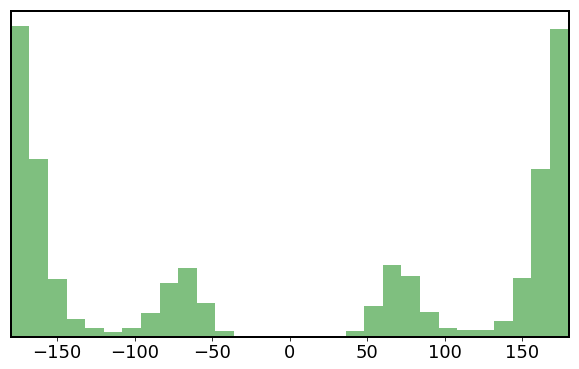

In [79]:
figure(figsize=(10,6))
ref = -13.
n, b, p = hist(np.vstack(inp)[:,0]*180./pi, bins=30, color = 'g', alpha=.5)
for p in gca().spines.values(): p.set_lw(2)
yticks([])
savefig('dih1_histogram.png', bbox_inches = 'tight')
xlim(-180,180)
xticks(fontsize=18)
#xlabel('Amid Dihedral Angle', fontsize=18)
#plot([ref,ref],[0,max(n)*.7],'k-')
#text(ref-40, max(n)*.8,'Xray Dihedral', fontsize=16)

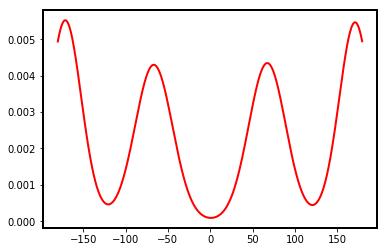

In [34]:
from scipy.stats import gaussian_kde
kernel = gaussian_kde(np.vstack(inp)[:,2]*180./pi)
xr = arange(-180, 180,.5)
y_kde = kernel.evaluate(xr)
plot(xr,y_kde,'r-',lw=2)
for p in gca().spines.values(): p.set_lw(2)

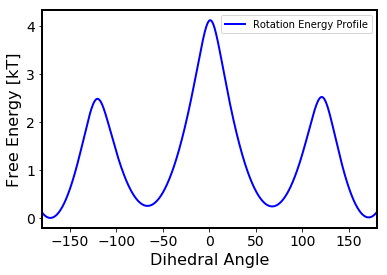

In [35]:
energy = -log(y_kde)
nenergy = energy - min( energy )
plot(xr, nenergy, 'b-',lw=2, label = 'Rotation Energy Profile')
xlim(-180,180)
xlabel('Dihedral Angle',fontsize=16)
ylabel('Free Energy [kT]',fontsize=16)
#grid(lw=2)
xticks( fontsize=14)
yticks( fontsize=14)
legend( loc='upper right')
for p in gca().spines.values(): p.set_lw(2)
savefig('dihedral1_energy.png')

<h3> Clustering and Selection of Conformers</h3>

In [36]:
# Generate a list with all interatomic distances as features
dist_lst = []
for i, atom in enumerate( m.atoms[:-1] ):
    for atom2 in m.atoms[i+1:]:
        dist_lst.append( [atom.id -1, atom2.id -1 ])


In [37]:
feat3 = coor.featurizer(topfile)
feat3.add_distances(dist_lst)
#feat3.describe()

In [38]:
inp = coor.load(traj_list, feat3)
source = coor.source( traj_list, top = topfile )

Box(children=(Text(value=u''), IntProgress(value=0)))

<h3> KMeans clustering on intramolecular distances</h3>

In [39]:
n_clusters = 20
cl_obj = coor.cluster_kmeans(inp, k=n_clusters)

Box(children=(Text(value=u''), IntProgress(value=0)))

Box(children=(Text(value=u''), IntProgress(value=0)))

16-05-19 15:21:08 pyemma.coordinates.clustering.kmeans.KmeansClustering[3] INFO     Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


In [40]:
# Generate samples from each cluster
samples = cl_obj.sample_indexes_by_cluster(range(n_clusters),1)
out_name_base = 'cluster'
out_names = []
for i in range(n_clusters):
    out_names.append( out_name_base+'%d.pdb' % i)
#print out_names

Box(children=(Text(value=u''), IntProgress(value=0)))

In [41]:
# save cluster representatives
coor.save_trajs(source, samples, outfiles = out_names)



16-05-19 15:21:16 coordinates.api INFO     Created file cluster0.pdb
16-05-19 15:21:16 coordinates.api INFO     Created file cluster1.pdb
16-05-19 15:21:16 coordinates.api INFO     Created file cluster2.pdb
16-05-19 15:21:16 coordinates.api INFO     Created file cluster3.pdb
16-05-19 15:21:16 coordinates.api INFO     Created file cluster4.pdb
16-05-19 15:21:16 coordinates.api INFO     Created file cluster5.pdb
16-05-19 15:21:16 coordinates.api INFO     Created file cluster6.pdb
16-05-19 15:21:16 coordinates.api INFO     Created file cluster7.pdb
16-05-19 15:21:16 coordinates.api INFO     Created file cluster8.pdb
16-05-19 15:21:16 coordinates.api INFO     Created file cluster9.pdb
16-05-19 15:21:16 coordinates.api INFO     Created file cluster10.pdb
16-05-19 15:21:16 coordinates.api INFO     Created file cluster11.pdb
16-05-19 15:21:16 coordinates.api INFO     Created file cluster12.pdb
16-05-19 15:21:16 coordinates.api INFO     Created file cluster13.pdb
16-05-19 15:21:16 coordinates.

['cluster0.pdb',
 'cluster1.pdb',
 'cluster2.pdb',
 'cluster3.pdb',
 'cluster4.pdb',
 'cluster5.pdb',
 'cluster6.pdb',
 'cluster7.pdb',
 'cluster8.pdb',
 'cluster9.pdb',
 'cluster10.pdb',
 'cluster11.pdb',
 'cluster12.pdb',
 'cluster13.pdb',
 'cluster14.pdb',
 'cluster15.pdb',
 'cluster16.pdb',
 'cluster17.pdb',
 'cluster18.pdb',
 'cluster19.pdb']

<h3> Cluster Statistics</h3>

<h4> Generate 1-dim array of all discretized (assigned to a cluster) trajectories</h4>

In [42]:
ii = np.concatenate(cl_obj.dtrajs)
#ii = np.vstack(cl_obj.dtrajs).flatten()

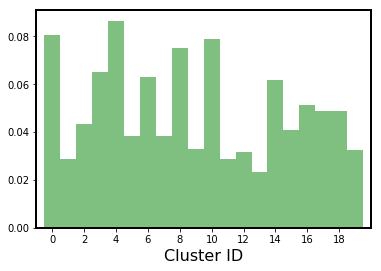

In [43]:
occupancy,b,p = hist(ii,bins=n_clusters,range=(-.5, 19.5),color='g',alpha=.5, normed=True)
xlim(-1,n_clusters)
xticks( range(0,n_clusters,2))
xlabel('Cluster ID', fontsize=16)
for p in gca().spines.values(): p.set_lw(2)

In [44]:
from pmx.geometry import *
lst  = glob('cluster*.pdb')

In [45]:
rmsd_mat = np.zeros( len(lst)**2).reshape( (len(lst),len(lst)))
for i, f1 in enumerate(lst[:-1]):
    for k, f2 in enumerate(lst[i+1:]):
        id1 = int(f1.split('.')[0].split('cluster')[1])
        id2 = int(f2.split('.')[0].split('cluster')[1])
        m1 = Model( f1 )
        m2 = Model( f2 )
        fit_atoms( m1.atoms, m2.atoms, m2.atoms )
        dd = rmsd( m1, m2 )
        rmsd_mat[id1][id2] = dd




In [46]:
import networkx as nx
G = nx.Graph()
cutoff = 0.8
for i in range( n_clusters ):
    G.add_node(i)
for i in range( n_clusters-1 ):
    for k in range( i+1, n_clusters):
        rm = rmsd_mat[i][k]
        if rm <= cutoff:
            G.add_edge( i,k )
#            dic[i].append( k )
#            print i, k
#        print i, k, rmsd_mat[i][k]
print G#print dic   

In [47]:
#nx.clustering(G)
#print occupancy
atoms_to_fit = ['C1','C2','C3']#,'C9']
ref_conf = Model('cluster0.pdb')
ref_atoms = ref_conf.residues[0].fetchm(atoms_to_fit)

cluster_lst = []
for cluster_ids in nx.connected_components(G):
    occ = 0
    for idx in cluster_ids:
        occ += occupancy[idx]
    cluster_lst.append( [cluster_ids, occ] )

sorted_cluster_lst =  sorted( cluster_lst, lambda a,b: cmp(b[1],a[1]) )


fpp = open('clusters_stats.txt','w')
for i, (ids, occ) in enumerate(sorted_cluster_lst):
    fp = open('MetaCluster%d.pdb' % i,'w')
    print >>fpp, 'MetaCluster%d.pdb -> Population = %4.2f%%' % (i,occ*100)
    for k, ii in enumerate(ids):
        fn = 'cluster%d.pdb' % ii
        m = Model(fn)
        atoms = m.residues[0].fetchm( atoms_to_fit )
        fit_atoms( ref_atoms, atoms, m.atoms )
        print >>fp, 'MODEL%5d' % k
        for atom in m.atoms:
            print >>fp, atom
        print >>fp, 'ENDMDL'
    fp.close()
fpp.close()


    #    print cluster_ids, occ

In [92]:
pwd

u'/home/seeliged/projects/mGluR1/SAR/MD/analysis/active'

In [109]:
l = open('/home/seeliged/projects/mGluR1/SAR/G09_TMPDIRc/Chloro.dat1').read().split('\n')[:-1]

In [113]:
x = []
y = []
for line in l:
    entr = line.split()
    print entr
    if entr[1] != 'NaN':
        x.append( float(entr[0])) 
        y.append( float( entr[1]))

['-180.00', '5.8775']
['-150.00', '3.0236']
['-120.00', '2.4971']
['-90.00', '2.4848']
['-60.00', '1.0655']
['-30.00', '0.1762']
['0.00', '0.3163']
['30.00', '0.0000']
['60.00', '0.9042']
['90.00', '2.4448']
['120.00', '1.9739']
['150.00', 'NaN']
['180.00', '5.8775']


In [135]:
from scipy.interpolate import UnivariateSpline
spl = UnivariateSpline(x,y)
spl.set_smoothing_factor(.02)
xs = np.linspace(-180,180,100)
ys = spl(xs)

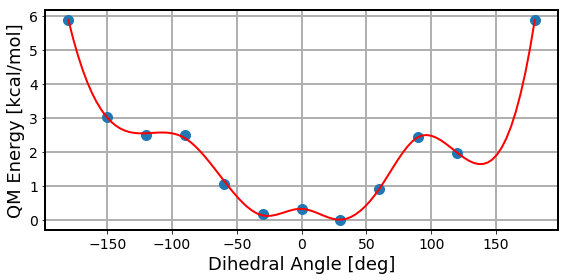

In [151]:
figure(figsize=(8,4))
plot(x,y,'o',markersize=10)
plot(xs,ys,'r',lw=2)
for p in gca().spines.values(): p.set_lw(2)
grid(lw=2)
xlabel('Dihedral Angle [deg]',fontsize=18)
ylabel('QM Energy [kcal/mol]',fontsize=18)
xticks(fontsize=14)
yticks(fontsize=14)
tight_layout()
savefig('Torsion.png')

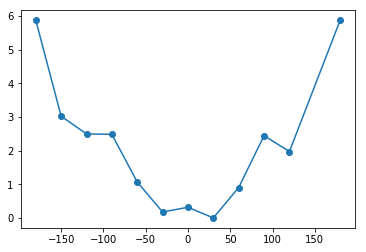

In [127]:
plot(x, y,'o-')